# What are linear trees?

From [this post](https://towardsdatascience.com/linear-tree-the-perfect-mix-of-linear-model-and-decision-tree-2eaed21936b7):

> Not everybody knows simple yet effective variations of the Decision Tree algorithm. These are known as Model Trees. They learn an optimal splitting of the training data, as in the standard Decision Tree, with the main difference that the **goodness of splits is evaluated fitting models**. A particular case of Model Trees is known as Linear Tree. This implies **having Linear Models in the leaves instead of simple constant approximations**. It can be seen as a simple improvement/alternative from the standard Decision Tree preserving at the same time the interpretation ability.

LightGBM includes the option for linear trees in its implementation. They might allow for better behaved models in some situations, especially when we want piecewise linear models. Below we show how to use them.

# Implementation

In [42]:
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split

## Create a stupidly simple dataset

In [70]:
n = 200
np.random.seed(1)
X = np.linspace(0, 6, n).reshape(n,1)
y = np.sin(X) + 0.1*np.random.randn(*X.shape)

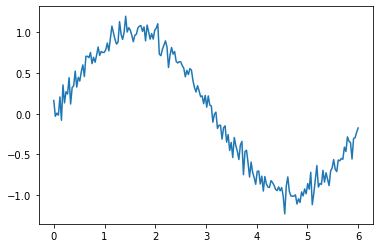

In [71]:
plt.plot(X, y)
plt.show()

### The `linear_tree` argument for some reason enters the `Dataset` object, not the train one
We will create two datasets, so we can compare

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

train_data_linear = lgb.Dataset(X_train, label=y_train,
                        params={
                            'linear_tree': True
                        })

train_data_normal = lgb.Dataset(X_train, label=y_train)

For the regular LightGBM API, one must pass a `params` object:

In [73]:
params = {
    "objective": "regression",
    "metric": "rmse",
    "num_leaves": 30,
    "learning_rate": 0.1,
    "verbosity": -1
}

model_linear = lgb.train(params, train_data_linear)
model_normal = lgb.train(params, train_data_normal)

/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


In [79]:
y_pred_linear = model_linear.predict(X_test, num_iteration=model.best_iteration)
y_pred_normal = model_normal.predict(X_test, num_iteration=model.best_iteration)

df = pd.DataFrame(X_test, columns=['x'])
df['y (regular trees)'] = y_pred_normal
df['y (linear trees)'] = y_pred_linear

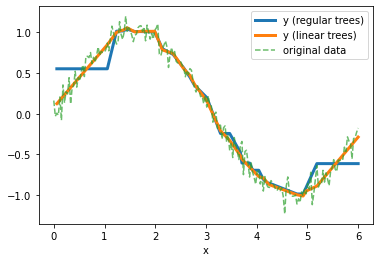

In [80]:
df.sort_values('x').set_index('x').plot(lw=3)
plt.plot(X, y, label='original data', alpha=0.7, linestyle='--')
plt.legend()
plt.show()

In [81]:
from sklearn.metrics import mean_squared_error

In [82]:
print(f"Linear trees error: {round(mean_squared_error(y_test, y_pred_linear),3)}")
print(f"Normal trees error: {round(mean_squared_error(y_test, y_pred_normal),3)}")

Linear trees error: 0.011
Normal trees error: 0.044
